# Build a predictive model for auto claims

In this section, we are aiming to answer 3 questions:

1. Which variables are good predictors of claim amounts?
    - Total claim amount
    - Injury claim amount
    - Property claim amount
    - Vehicle claim amount


2. Which variables are good predictors of fraud as seen in the column called “fraud_reported (Y/N)”?

3. How would you assign a score from 1-100 to each claim as an indicator of the extent to which this claim is fraudulent?

Below I build a series of analysis and model, let's check what we will get from the dataset!

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import cm, pyplot

df = pd.read_csv("datasets_45152_82501_insurance_claims.csv.14XpHA")

In [2]:
df.head(3).T
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Get the info from the dataset, the data is 1,000 entries and 40 features, with 19 numerical and 21categorical features at the first glance

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
months_as_customer             1000 non-null int64
age                            1000 non-null int64
policy_number                  1000 non-null int64
policy_bind_date               1000 non-null object
policy_state                   1000 non-null object
policy_csl                     1000 non-null object
policy_deductable              1000 non-null int64
policy_annual_premium          1000 non-null float64
umbrella_limit                 1000 non-null int64
insured_zip                    1000 non-null int64
insured_sex                    1000 non-null object
insured_education_level        1000 non-null object
insured_occupation             1000 non-null object
insured_hobbies                1000 non-null object
insured_relationship           1000 non-null object
capital-gains                  1000 non-null int64
capital-loss                   1000 non-null int64
incident_date    

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,5.462386e+05,2.570630e+05,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
insured_zip,1000.0,5.012145e+05,7.170161e+04,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00


#### Within the 1000 cases, there are 247 cases reported as fraud versus 753 normal cases.

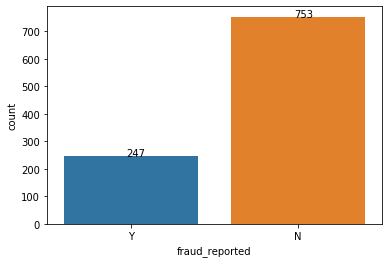

In [5]:
fg1 = sns.countplot(df['fraud_reported'], label="Count")
for p in fg1.patches:
    fg1.annotate(p.get_height(), (p.get_x()+0.375, p.get_height()+0.15))

In [6]:
#drop columns with all N/As
df.dropna(axis = 1, how = 'all', inplace = True)
df.drop(['policy_number', 'insured_zip'], axis = 1, inplace = True)

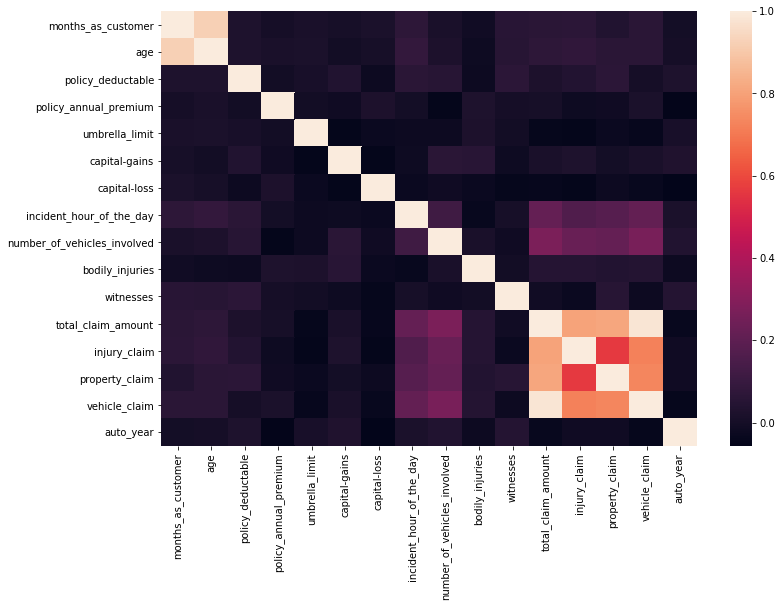

In [7]:
plt.figure(figsize = (12,8))
sns.heatmap(df.corr())

In [8]:
numerics = ['int64', 'float64']
numdf = df.select_dtypes(include=numerics)
numdf['fraud_reported'] = df['fraud_reported']

/Users/Naitan_Chang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


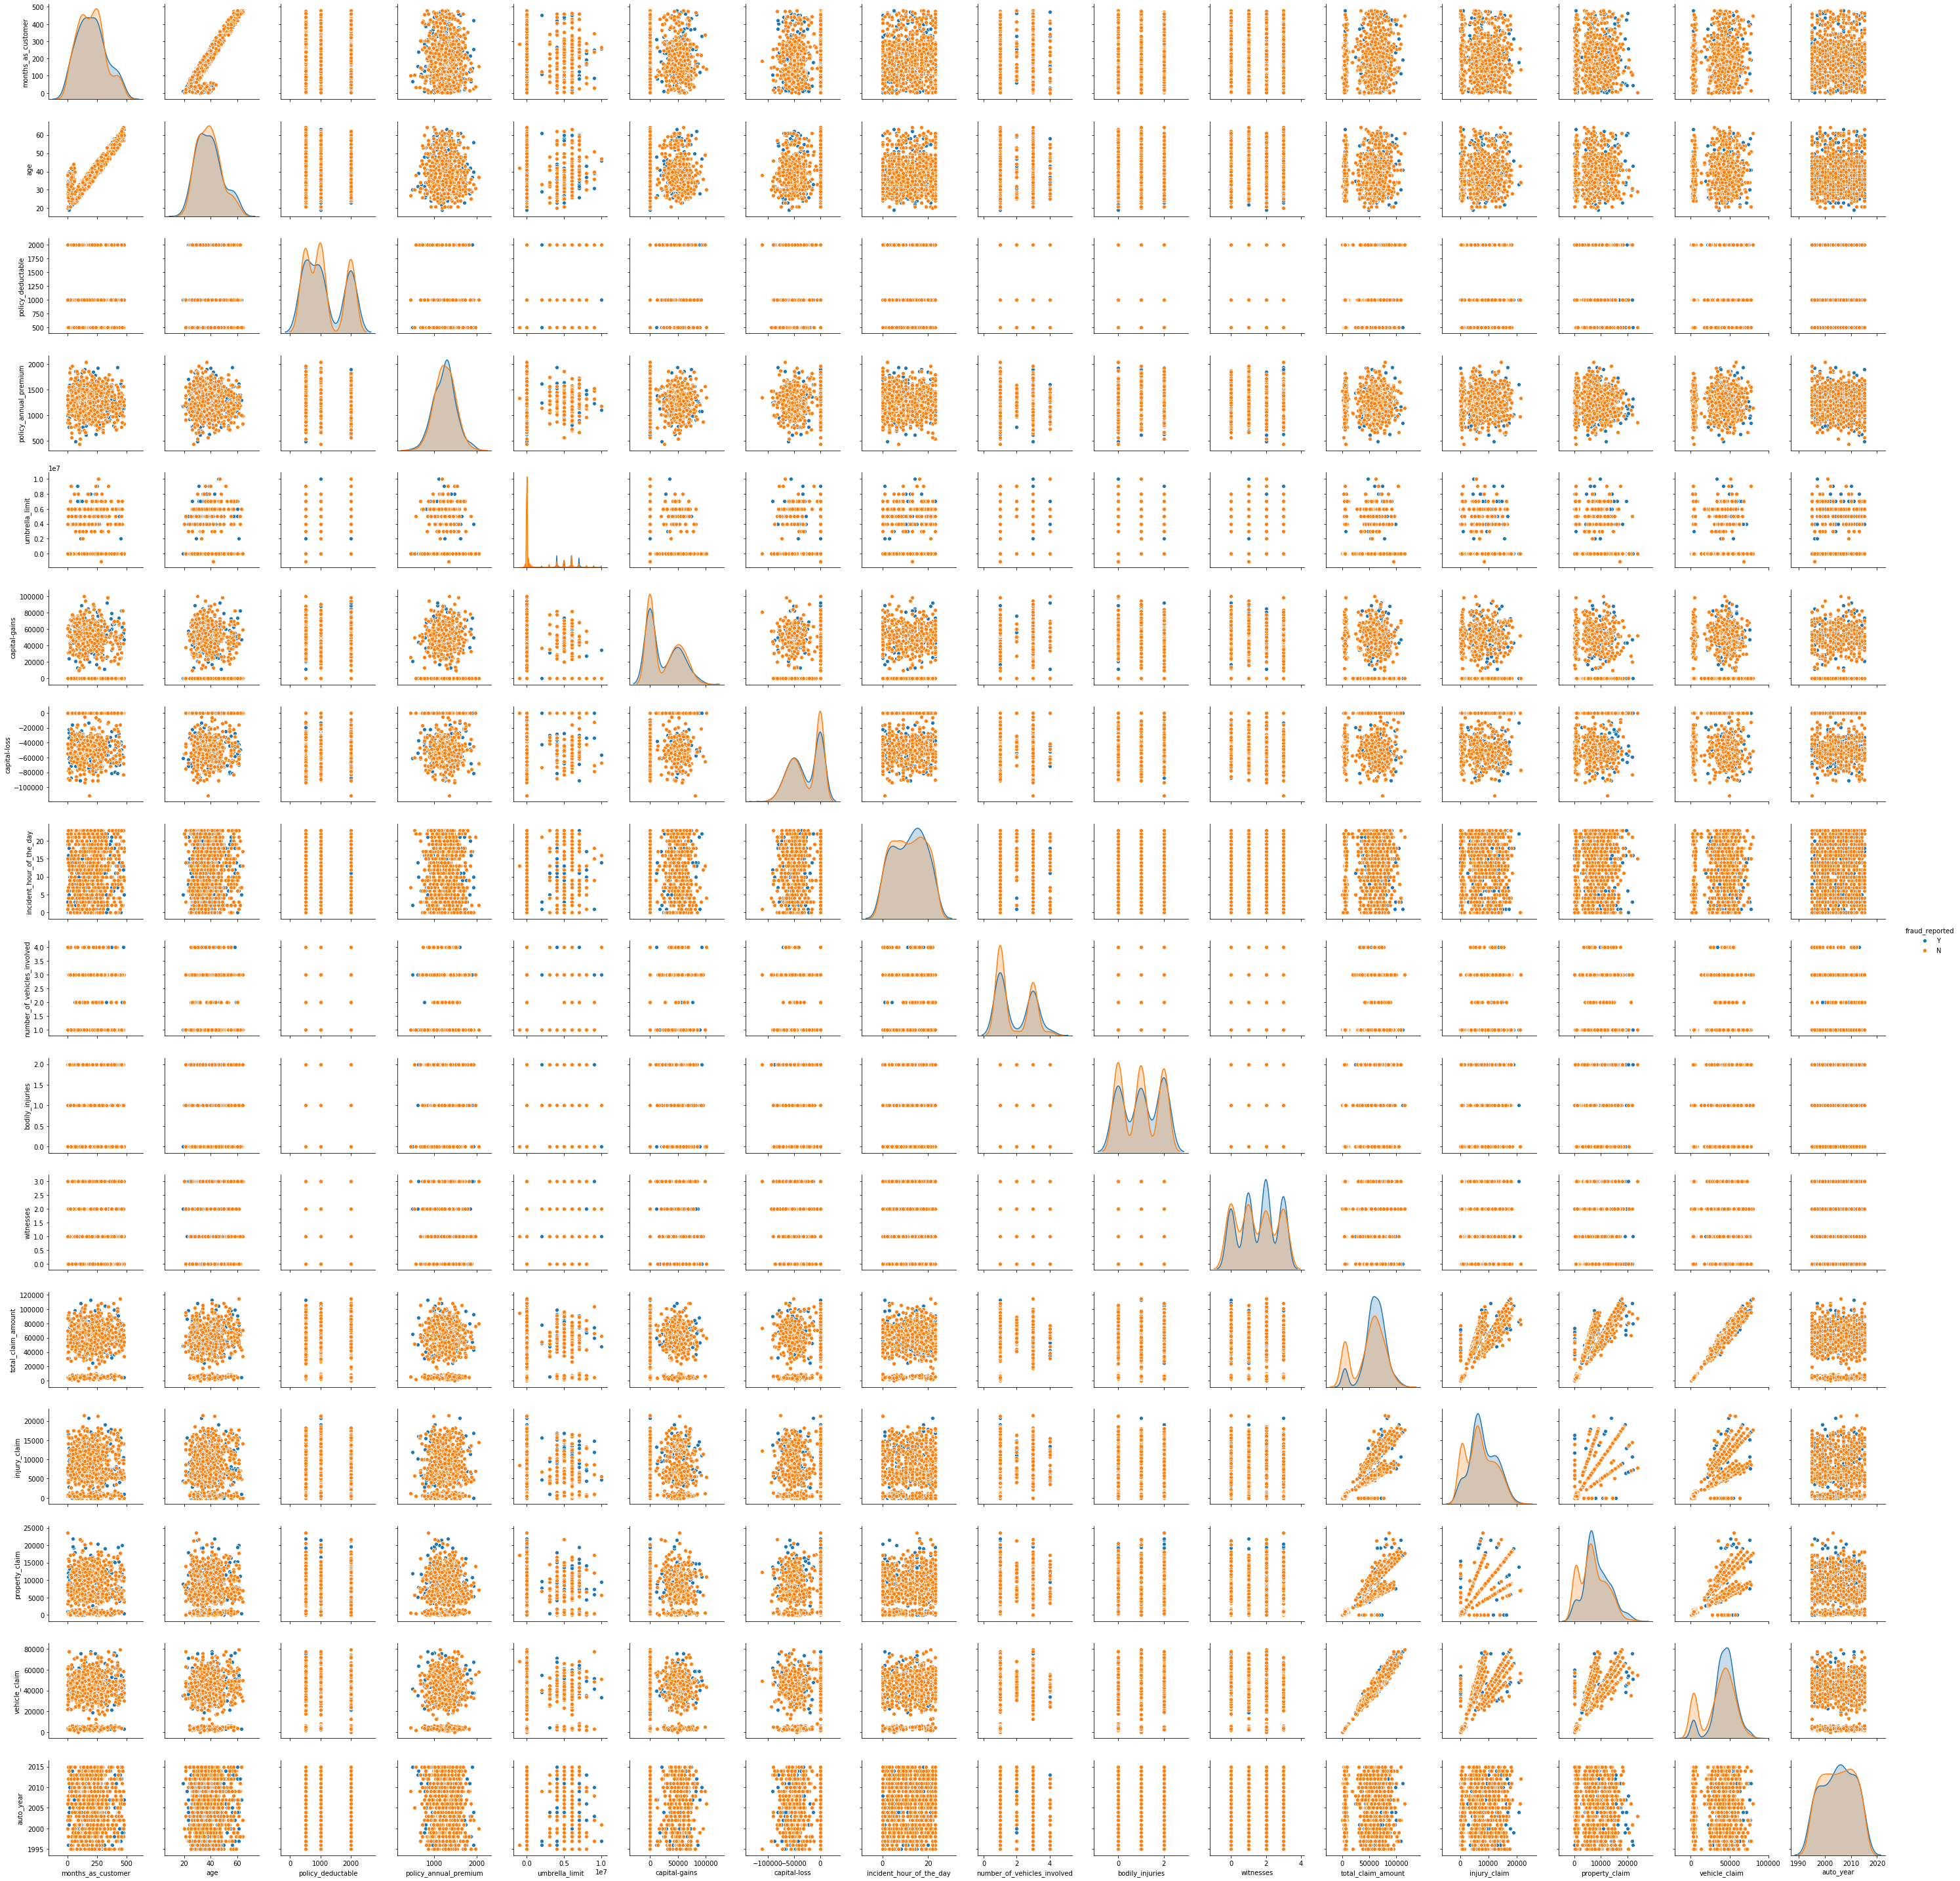

In [86]:
g = sns.pairplot(numdf, hue="fraud_reported")

In [9]:
# adjust the datatype of date from object to time
df['policy_bind_date'] = df['policy_bind_date'].astype('datetime64[ns]')
df['incident_date'] = pd.to_datetime(df.incident_date) + df.incident_hour_of_the_day.astype('timedelta64[h]')


#the len(incident_location) == rows of the data
df.drop(['incident_location', 'incident_city', 'incident_hour_of_the_day', 'auto_model'], axis = 1, inplace = True)

In [10]:
df_modeling = df

In [11]:
#adjust categorical data
df_modeling['insured_sex'].replace(['MALE', 'FEMALE'], [0, 1], inplace = True)
df_modeling['fraud_reported'].replace(['Y', 'N'], [1, 0], inplace = True)

In [12]:
#new feature from policy_csl: csl_numerator and csl_denominator
df_modeling['csl_numerator'] = df_modeling.policy_csl.str[:3]
df_modeling['csl_denominator'] = df_modeling.policy_csl.str[4:]
df_modeling.drop(columns = ['policy_csl'], inplace = True)
convert_dict = {'csl_numerator': int, 
                'csl_denominator': int
               } 
  
df_modeling = df_modeling.astype(convert_dict) 


In [13]:
# build ordinary categorical feature
map_education = {"High School" : 1, "Associate": 2, "College": 3, "Masters": 4, "PhD": 5, "JD": 6, "MD": 7}
map_incident_severity = {"Trivial Damage" : 1, "Minor Damage": 2, "Major Damage": 3, "Total Loss": 4}

df_modeling['insured_education_level'] = df_modeling['insured_education_level'].map(map_education)
df_modeling['incident_severity'] = df_modeling['incident_severity'].map(map_incident_severity)


In [14]:
import category_encoders as ce
cat_cols = df_modeling.select_dtypes(include='object').columns
ont_hot_cols = ['policy_state', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 
                'incident_type', 'collision_type', 'authorities_contacted', 'incident_state', 
                'property_damage', 'police_report_available', 'auto_make']
# 'incident_location'
for cat in ont_hot_cols:
    df_modeling = pd.get_dummies(df_modeling, columns=[cat])


In [15]:
cols = list(df_modeling.columns)
cols = [c for c in cols if c not in ["policy_bind_date", 'incident_date', 'fraud_reported']]
print('Total features used for the dataset: {:}'
         .format(len(cols)))

Total features used for the dataset: 103


In [16]:
four_features = ['total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim']
X_all_features = df_modeling[cols]
X_claims = df_modeling[four_features]
y = df_modeling['fraud_reported']

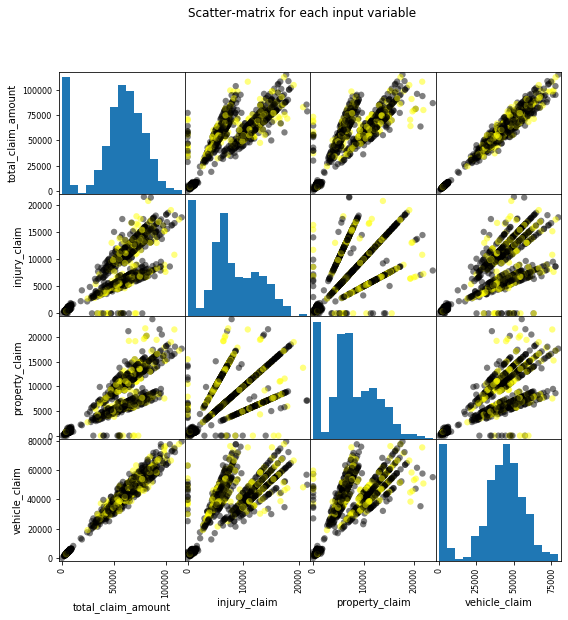

In [17]:
cmap = cm.get_cmap('gnuplot')
# g = sns.pairplot(claim_report, hue="fraud_reported")
scatter = scatter_matrix(X_claims, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('Fraud_scatter_matrix')

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all_features, y, random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (750, 103)
Training Labels Shape: (750,)
Testing Features Shape: (250, 103)
Testing Labels Shape: (250,)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
def logis_model(X_train_set, y_train_set, X_test_set, y_test_set):
    logreg = LogisticRegression()
    logreg.fit(X_train_set, y_train_set)
    
    y_pred_train = logreg.predict(X_train_set)
    y_pred_test = logreg.predict(X_test_set)

    print('Accuracy of Logistic regression classifier on training set: {:.2f}'
         .format(logreg.score(X_train_set, y_train_set)))
    print('Accuracy of Logistic regression classifier on test set: {:.2f}'
         .format(logreg.score(X_test_set, y_test_set)))
    
    return y_pred_train, y_pred_test

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data
from IPython.display import Image 

def DecisionTree_model(X_train_set, y_train_set, X_test_set, y_test_set):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=3).fit(X_train_set, y_train_set)
    y_pred_train = clf.predict(X_train_set)
    y_pred_test = clf.predict(X_test_set)
    print('Accuracy of Decision Tree classifier on training set: {:.2f}'
         .format(clf.score(X_train_set, y_train_set)))
    print('Accuracy of Decision Tree classifier on test set: {:.2f}'
         .format(clf.score(X_test_set, y_test_set)))
    return y_pred_train, y_pred_test, clf

/Users/Naitan_Chang/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
def knn_model(X_train_set, y_train_set, X_test_set, y_test_set):
    knn = KNeighborsClassifier()
    knn.fit(X_train_set, y_train_set)
    y_pred_train = knn.predict(X_train_set)
    y_pred_test = knn.predict(X_test_set)
    print('Accuracy of K-NN classifier on training set: {:.2f}'
         .format(knn.score(X_train_set, y_train_set)))
    print('Accuracy of K-NN classifier on test set: {:.2f}'
         .format(knn.score(X_test_set, y_test_set)))
    return y_pred_train, y_pred_test

In [23]:
def print_confusion_matrix(y_fit, y_train, class_names, title, figsize = (5,4), fontsize=14):
    cm_new = pd.DataFrame(y_train)
    cm_new['y_pred_train'] = y_fit
    c_matrix = confusion_matrix(y_train, y_fit)
    df_cm = pd.DataFrame(
        c_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    # precision tp / (tp + fp)
    precision = precision_score(y_fit, y_train)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_fit, y_train)
    print('Recall: %f' % recall)
    return cm_new

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def input_for_roc(dataframe, dtypes):
    fpr, tpr, thresholds = roc_curve(dataframe[dataframe.columns[0]], dataframe[dataframe.columns[1]])
    auc = roc_auc_score(dataframe[dataframe.columns[0]], dataframe[dataframe.columns[1]])
    print(dtypes, 'AUC: %.2f' % auc)
    return fpr, tpr, thresholds

def plot_roc_curve(dataframe, dtypes, ylab='True Positive Rate', patch = None):
    fpr, tpr, thresholds = input_for_roc(dataframe, dtypes)
    
    #plot the ROC and random
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel(ylab)
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    
    
    plt.show()

In [25]:
y_logi_train, y_logi_test = logis_model(X_train, y_train, X_test, y_test)

Accuracy of Logistic regression classifier on training set: 0.84
Accuracy of Logistic regression classifier on test set: 0.72


/Users/Naitan_Chang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision: 0.406780
Recall: 0.808989


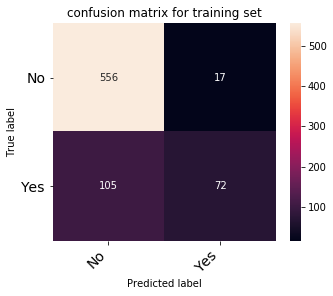

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm_logis_train= print_confusion_matrix(y_logi_train, y_train, ['No','Yes'], "confusion matrix for training set")


Precision: 0.185714
Recall: 0.481481


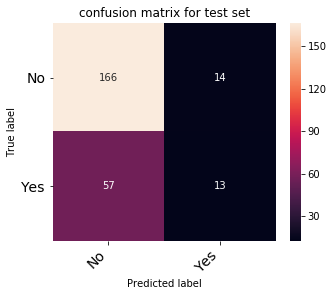

In [27]:
cm_logis_test = print_confusion_matrix(y_logi_test, y_test, ['No','Yes'], "confusion matrix for test set")

Training AUC: 0.69


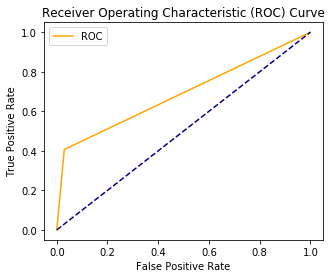

Test AUC: 0.55


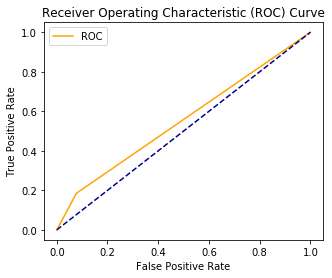

(None, None)

In [28]:
plot_roc_curve(cm_logis_train, 'Training'), plot_roc_curve(cm_logis_test, 'Test')

In [29]:
y_dtree_train, y_dtree_test, clf = DecisionTree_model(X_train, y_train, X_test, y_test)

Accuracy of Decision Tree classifier on training set: 0.85
Accuracy of Decision Tree classifier on test set: 0.85


Precision: 0.853107
Recall: 0.631799


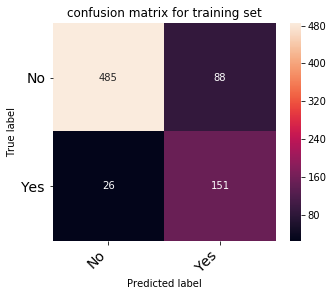

In [30]:
cm_dtree_train = print_confusion_matrix(y_dtree_train, y_train, ['No','Yes'], "confusion matrix for training set")

Precision: 0.800000
Recall: 0.700000


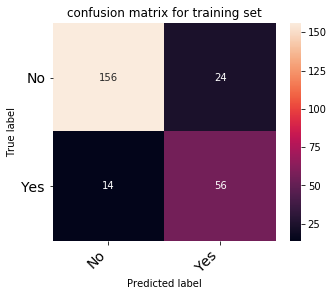

In [31]:
cm_dtree_test = print_confusion_matrix(y_dtree_test, y_test, ['No','Yes'], "confusion matrix for training set")

Training AUC: 0.85


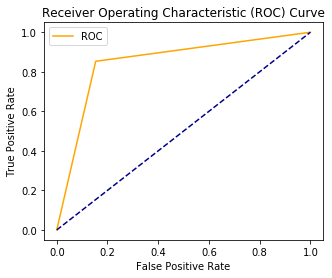

Test AUC: 0.83


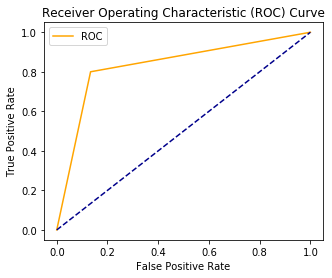

(None, None)

In [32]:
plot_roc_curve(cm_dtree_train, 'Training'), plot_roc_curve(cm_dtree_test, 'Test')

Variable: incident_severity    Importance: 0.53
Variable: insured_hobbies_chess Importance: 0.28
Variable: insured_hobbies_cross-fit Importance: 0.14
Variable: property_claim       Importance: 0.05
Variable: months_as_customer   Importance: 0.0
Variable: age                  Importance: 0.0
Variable: policy_deductable    Importance: 0.0
Variable: policy_annual_premium Importance: 0.0
Variable: umbrella_limit       Importance: 0.0
Variable: insured_sex          Importance: 0.0


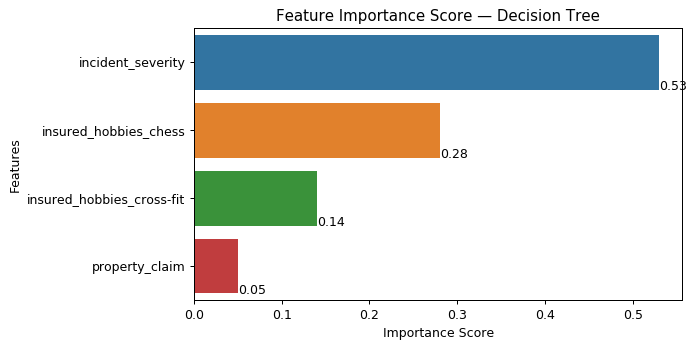

In [33]:
# def feature_importance():
importance = clf.feature_importances_

# List of tuples with variable and importance
feature_importances = [(feature, round(important, 2)) for feature, important in zip(cols, importance)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]];


# show_values_on_bars(feature_importances[:10], 'h')
plt.figure(num=None, figsize=(7, 4), dpi=90);
important_feature = [x[0] for x in feature_importances[:4]]
important_score = [x[1] for x in feature_importances[:4]]
fg2 = sns.barplot(x = important_score, y = important_feature)
for p in fg2.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height()
    value = p.get_width()
    fg2.text(_x, _y, value, ha="left")

plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Decision Tree')
plt.show()

In [34]:
knn_y_train, knn_y_test = knn_model(X_train, y_train, X_test, y_test)

Accuracy of K-NN classifier on training set: 0.79
Accuracy of K-NN classifier on test set: 0.64


Precision: 0.276836
Recall: 0.644737


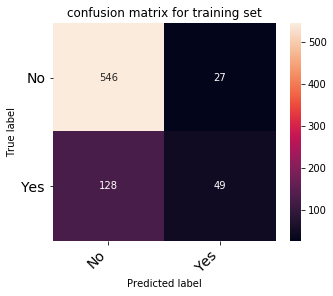

In [35]:
cm_knn_train = print_confusion_matrix(knn_y_train, y_train, ['No','Yes'], "confusion matrix for training set")

Precision: 0.114286
Recall: 0.228571


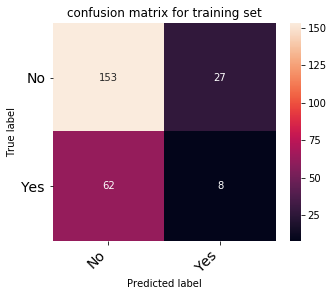

In [36]:
cm_knn_test = print_confusion_matrix(knn_y_test, y_test, ['No','Yes'], "confusion matrix for training set")

Training AUC: 0.61


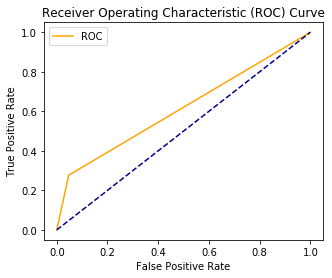

Test AUC: 0.48


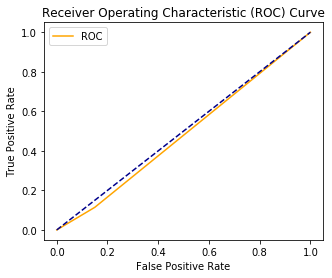

(None, None)

In [37]:
plot_roc_curve(cm_knn_train, 'Training'), plot_roc_curve(cm_knn_test, 'Test')

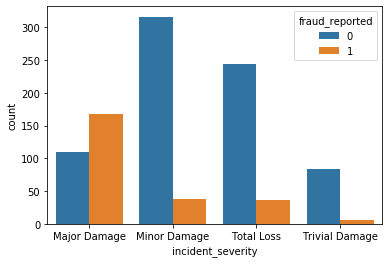

In [42]:
df_q2 = df[df['fraud_reported'] == 1]
ax1 = sns.countplot(x="incident_severity", hue='fraud_reported', data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

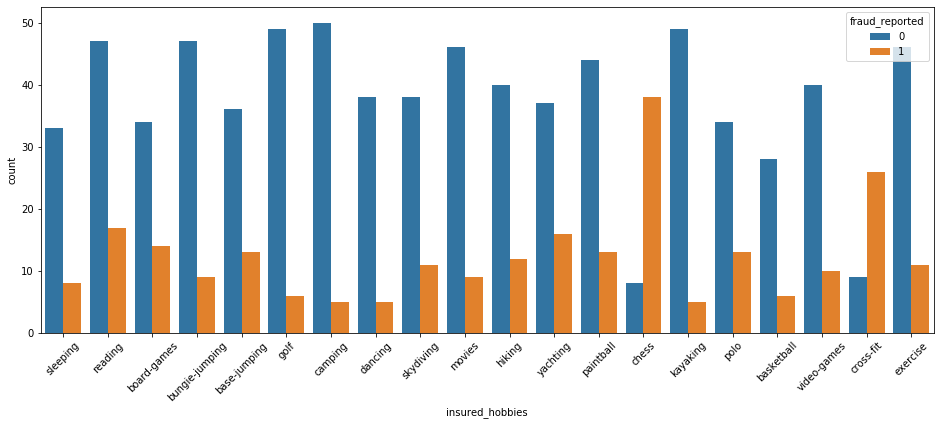

In [45]:
plt.figure(figsize=(16,6))
ax2 = sns.countplot(x="insured_hobbies", hue='fraud_reported', data=df)
plt.xticks(rotation = 45)